In [6]:
import os, sys, glob
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import seaborn as sb
import lightkurve as lk
from astropy.io import fits

%matplotlib inline
path = os.path.dirname(os.getcwd()) 

sys.path.append(path)
from exba import EXBA
lk.__version__

'2.0.3.dev'

In [7]:
channels = np.sort(np.array(os.listdir('%s/data/EXBA/' % path), dtype=int))
print(channels)
quarters = np.sort(np.array(os.listdir('%s/data/EXBA/%i/' % (path, channels[1])), dtype=int))
print(quarters)

[ 1  2  3  4  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28
 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52
 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76
 77 78 79 80 81 82 83 84]
[ 5  6  7  8  9 10 11 12 13 14 15 16 17]


# Load all CSV catalogs from precomputed EXBAs

In [8]:
gaia_sources = []
for q in tqdm(quarters, desc="Quarters", leave=True):
    for ch in tqdm(channels, desc="Channels", leave=False):
        aux = pd.read_csv("%s/data/EXBA/%i/%i/gaia_dr2_xmatch.csv" % 
                          (path, ch, q))
        gaia_sources.append(aux)
        
df_concat = pd.concat(gaia_sources).drop_duplicates('designation').set_index('designation')
df_concat.shape

Quarters:   0%|          | 0/13 [00:00<?, ?it/s]

Channels:   0%|          | 0/80 [00:00<?, ?it/s]

Channels:   0%|          | 0/80 [00:00<?, ?it/s]

Channels:   0%|          | 0/80 [00:00<?, ?it/s]

Channels:   0%|          | 0/80 [00:00<?, ?it/s]

Channels:   0%|          | 0/80 [00:00<?, ?it/s]

Channels:   0%|          | 0/80 [00:00<?, ?it/s]

Channels:   0%|          | 0/80 [00:00<?, ?it/s]

Channels:   0%|          | 0/80 [00:00<?, ?it/s]

Channels:   0%|          | 0/80 [00:00<?, ?it/s]

Channels:   0%|          | 0/80 [00:00<?, ?it/s]

Channels:   0%|          | 0/80 [00:00<?, ?it/s]

Channels:   0%|          | 0/80 [00:00<?, ?it/s]

Channels:   0%|          | 0/80 [00:00<?, ?it/s]

(9172, 102)

In [9]:
df_concat["abs_gmag"] = (df_concat.phot_g_mean_mag + 
                          5 * (np.log10(df_concat.parallax/1e3) + 1))
df_concat["distance"] = 1e3 / df_concat.parallax
good_parallax = df_concat.parallax > 0.01

/Users/jorgemarpa/.pyenv/versions/adap/lib/python3.8/site-packages/pandas/core/arraylike.py:274: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


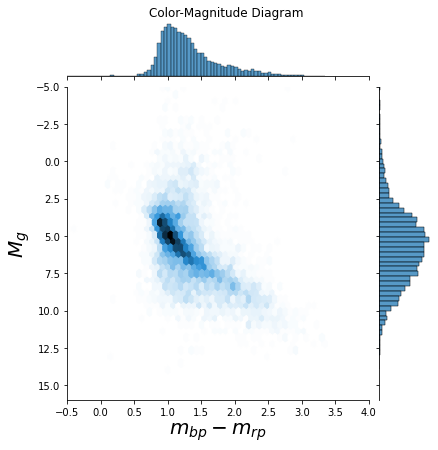

In [10]:
ax = sb.jointplot(
            data=df_concat,
            x="bp_rp",
            y="abs_gmag",
            kind="hex",
            xlim=(-0.5, 4),
            ylim=(16, -5),
        )
# ax.fig.axes[0].invert_yaxis()
ax.fig.suptitle("Color-Magnitude Diagram", y=1.01)
ax.fig.axes[0].set_ylabel(r"$M_{g}$", fontsize=20)
ax.fig.axes[0].set_xlabel(r"$m_{bp} - m_{rp}$", fontsize=20)
plt.show()

In [11]:
interesting = ['Gaia DR2 2076789727566520192']
df_concat.loc[interesting][["parallax", "distance"]]

,parallax,distance
designation,,
Gaia DR2 2076789727566520192,0.250323,3994.841557


### Load Kepler-Gaia Catalog

In [12]:
from astropy.table import Table

In [13]:
kep_data = Table.read("%s/data/kepler_dr2_4arcsec.fits" % (path), format="fits")
kep_data["abs_gmag"] = (kep_data['phot_g_mean_mag'] + 
                         5.*(np.log10(kep_data['parallax']/1.e3) + 1.))

<ipython-input-13-88c67a49f7e6>:3: RuntimeWarning: invalid value encountered in log10
  5.*(np.log10(kep_data['parallax']/1.e3) + 1.))


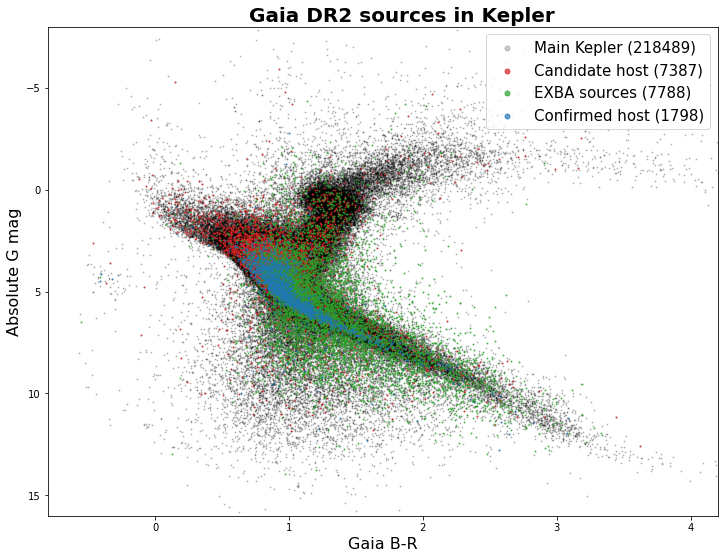

In [66]:
fig,ax = plt.subplots(1,1,figsize=(12,9))

filter = (kep_data['phot_g_mean_mag'] <= 20.) & (kep_data['parallax'] > 0.01)
ax.scatter(kep_data['bp_rp'], kep_data['abs_gmag'], 
           alpha=0.2, color='k', s=1,
           label='Main Kepler ({0})'.format(sum(filter)))

filter2 = (kep_data['planet?'] == 'cand') & filter
ax.scatter(kep_data['bp_rp'][filter2], kep_data['abs_gmag'][filter2], 
           alpha=0.7, s=1, color='tab:red',
           label='Candidate host ({0})'.format(sum(filter2)))

# EXBA
ax.scatter(df_concat['bp_rp'][good_parallax], 
           df_concat['abs_gmag'][good_parallax], 
           alpha=0.7, s=1, color='tab:green',
           label='EXBA sources ({})'.format(sum(good_parallax)))

filter2 = (kep_data['planet?'] == 'conf') & filter
ax.scatter(kep_data['bp_rp'][filter2], kep_data['abs_gmag'][filter2], 
           alpha=0.7, s=1, color='tab:blue',
           label='Confirmed host ({0})'.format(sum(filter2)))

# interesting sources from EXBA
#ax.scatter(df_concat.loc[interesting]['bp_rp'], 
#           df_concat.loc[interesting]['abs_gmag'], 
#           marker="*",
#           alpha=0.7, s=100, color='darkorange',
#           label='EXBA interesting')

ax.set_xlabel('Gaia B-R', fontsize=16)
ax.set_ylabel('Absolute G mag', fontsize=16)
ax.set_ylim([16,-8])
ax.set_xlim([-0.8,4.2])
ax.text(0.30,1.01,'Gaia DR2 sources in Kepler', transform=plt.gca().transAxes, 
        fontweight='bold', fontsize=20)
ax.legend(loc='upper right', fontsize=15, markerscale=5)

plt.show()

In [67]:
mags = kep_data['phot_g_mean_mag'][filter].quantity.value.astype(np.float)

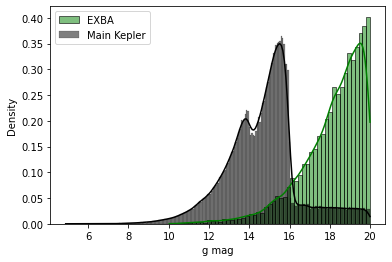

In [68]:
ax = sb.histplot(df_concat['phot_g_mean_mag'].values, kde=True, 
            color='green', stat='density', label='EXBA')
sb.histplot(mags, kde=True, color='k', ax=ax, stat='density', label='Main Kepler')
plt.legend(loc='upper left')
plt.xlabel('g mag')
plt.show()